rm -rf *.csv

In [1]:
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

use_gpu = torch.cuda.is_available()
print(use_gpu)

train_path = '/gpfs/data/denizlab/Datasets/Public/CheXpert-v1.0/train.csv'
valid_path = '/gpfs/data/denizlab/Datasets/Public/CheXpert-v1.0/valid.csv'


Traindata = pd.read_csv(train_path)
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
#Traindata = Traindata[500:]
Traindata.to_csv('/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/U1-V1/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Validdata = pd.read_csv(valid_path)
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/U1-V1/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))

# Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
# Testdata.to_csv('/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/test_mod.csv', index = False)
# print("Test data length:", len(Testdata))

pathFileTrain = '/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/U1-V1/train_mod.csv'
pathFileValid = '/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/U1-V1/valid_mod.csv'
# pathFileTest = '/gpfs/data/denizlab/Users/skr2369/Chexpert/CheXpert-v1/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 14       # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                
                image_names.append('/gpfs/data/denizlab/Datasets/Public/' + image_name)
        
#                 image_names.append('./' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)
    

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
# transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones")
print("Train data length:", len(datasetTrain))
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=20, pin_memory=True)


datasetValid = CheXpertDataSet(pathFileValid, transformSequence)
print("Valid data length:", len(datasetValid))
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize, 
                           shuffle = False, num_workers = 2, pin_memory = True)

# data("Test data length:", len(datasetTest))


class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
#             lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst))#, "Valid loss: {:.3f}".format(lossv))
            
            if losst < lossMIN:
                lossMIN = losst
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 
                           'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(losst))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(losst))

        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

True
Train data length: 191027
Valid data length: 202
Train data length: 191027
Valid data length: 202


In [2]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [3]:
# densenet model
class densenet_model(nn.Module):
    def __init__(self, size, features_dim, out_size, pretrained=False):
        super(densenet_model, self).__init__()
        
        if size==121:
            self.backbone = torchvision.models.densenet121(pretrained = False)
        else:
            raise NotImplementedError(f"ResNet with size {size} is not implemented!")

        #self.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.feature_dim_in = self.backbone.classifier.in_features
        #self.backbone.classifier = nn.Linear(in_features=self.feature_dim_in, out_features=features_dim, bias=True)
        self.backbone.classifier = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(features_dim, out_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [4]:
# resnet model
class resnet_model(nn.Module):
    def __init__(self, size, features_dim, out_size, pretrained=False):
        super(resnet_model, self).__init__()
        
        if size==18:
            self.backbone = torchvision.models.resnet18(pretrained=pretrained)
        elif size==50:
            self.backbone = torchvision.models.resnet50(pretrained=pretrained)
        elif size==101:
            self.backbone = torchvision.models.resnet101(pretrained=pretrained)
        else:
            raise NotImplementedError(f"ResNet with size {size} is not implemented!")

        #self.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.feature_dim_in = self.backbone.fc.weight.shape[1]
        #self.backbone.fc = nn.Linear(in_features=self.feature_dim_in, out_features=features_dim, bias=True)
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(features_dim, out_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [5]:
# vit model
class vit_model(nn.Module):
    def __init__(self, size, features_dim, out_size, pretrained=False, freeze_pos_embed=False, **kwargs):
        super(vit_model, self).__init__()
        
        if freeze_pos_embed:
            pass
        else:
            if size=="base":
                model_kwargs = dict(
                    patch_size=16, embed_dim=768, depth=12, num_heads=12, num_classes=0, **kwargs
                )
                self.backbone = _create_vision_transformer("vit_base_patch16_224", pretrained=pretrained, **model_kwargs)
            else:
                pass

        self.classifier = nn.Sequential(
            nn.Linear(features_dim, out_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [6]:
size = 50
features_dim = 2048
out_size = 14

model = resnet_model(size, features_dim, out_size, pretrained=True).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()
#model = model.cuda()

In [7]:
from timm.models.vision_transformer import _create_vision_transformer
from timm.models.layers import PatchEmbed
from timm.models.vision_transformer import VisionTransformer, _cfg

/gpfs/share/skynet/apps/anaconda3/envs/opence_env_1.5.1/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [155]:
size = "base"
features_dim = 768
out_size = nnClassCount
model = vit_model(size, features_dim, out_size, pretrained=True).cuda() # Step 0: Initialize global model and load the m
model = torch.nn.DataParallel(model).cuda()

In [156]:
# model = DenseNet121(nnClassCount).cuda() # Step 0: Initialize global model and load the model
# model = torch.nn.DataParallel(model).cuda()

In [8]:
ls

 Performance_Check.ipynb  'grad_cam visualization.ipynb'   model_saved/
 VIT_SIMCLR.err            gradcam++_cam.jpg               results/
 VIT_SIMCLR.out            gradcam_cam.jpg                 results_s1000/
 VIT_SLIP_VICREG.err       gradcam_result/                 results_s1666/
 VIT_SLIP_VICREG.out       m-epoch_FL1.pth.tar             results_s2022/
 VIT_VICREG.err            m-epoch_FL2.pth.tar             results_s2023/
 VIT_VICREG.out            m-epoch_FL3.pth.tar             results_s42/
 __pycache__/              m-epoch_FL_ResNet1.pth.tar      submitit.bsub
 ablationcam_cam.jpg       m-epoch_FL_ResNet2.pth.tar      train_mod.csv
 base3.py                  m-epoch_FL_ResNet3.pth.tar      valid_mod.csv


In [9]:
def load_model(load_path, model):
    load_path = load_path
    checkpoint = torch.load(load_path)
    state_dict = {k.replace("img_backbone.", "module."): v for k, v in checkpoint['state_dict'].items()}
    load_status = model.load_state_dict(state_dict, strict=False)
    print(load_status)

# ResNet-50

## Original

In [226]:
load_path = "/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10003.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [227]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7976843762868436
No Finding   0.8697552447552448
Enlarged Cardiomediastinum   0.35787923416789397
Cardiomegaly   0.7673796791443851
Lung Opacity   0.8810457516339869
Lung Lesion   0.7064676616915423
Edema   0.9418154761904762
Consolidation   0.786029411764706
Pneumonia   0.6739690721649485
Atelectasis   0.7513910761154855
Pneumothorax   0.936996336996337
Pleural Effusion   0.932518115942029
Pleural Other   0.8308457711442786
Fracture   0.9338040600176523


In [221]:
load_path = '/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10002.pth.tar'
load_model(load_path, model)

<All keys matched successfully>


In [222]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7975465290981467
No Finding   0.8955419580419581
Enlarged Cardiomediastinum   0.5713303878252332
Cardiomegaly   0.8096033868092691
Lung Opacity   0.9072900955253896
Lung Lesion   0.21890547263681592
Edema   0.9358630952380952
Consolidation   0.8797794117647058
Pneumonia   0.7680412371134021
Atelectasis   0.8143832020997376
Pneumothorax   0.8996336996336995
Pleural Effusion   0.9274230072463767
Pleural Other   0.8159203980099503
Fracture   0.9243895263312739


In [223]:
load_path = '/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10003.pth.tar'
load_model(load_path, model)

<All keys matched successfully>


In [224]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7976843762868436
No Finding   0.8697552447552448
Enlarged Cardiomediastinum   0.35787923416789397
Cardiomegaly   0.7673796791443851
Lung Opacity   0.8810457516339869
Lung Lesion   0.7064676616915423
Edema   0.9418154761904762
Consolidation   0.786029411764706
Pneumonia   0.6739690721649485
Atelectasis   0.7513910761154855
Pneumothorax   0.936996336996337
Pleural Effusion   0.932518115942029
Pleural Other   0.8308457711442786
Fracture   0.9338040600176523


## CLIP

In [29]:
load_path = "model_saved/m-epoch_FL_resnet_clip1.pth.tar"
load_model(load_path, model)

In [30]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8034623921263019
No Finding   0.8918269230769231
Enlarged Cardiomediastinum   0.5183112420225823
Cardiomegaly   0.7817513368983958
Lung Opacity   0.8785319255907491
Lung Lesion   0.3681592039800995
Edema   0.9171130952380953
Consolidation   0.8558823529411765
Pneumonia   0.8846649484536082
Atelectasis   0.8155380577427821
Pneumothorax   0.8578754578754579
Pleural Effusion   0.8966259057971016
Pleural Other   0.8756218905472637
Fracture   0.9031087574776894


In [31]:
load_path = "model_saved/m-epoch_FL_resnet_clip2.pth.tar"
load_model(load_path, model)

In [32]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7903021631972967
No Finding   0.9047202797202797
Enlarged Cardiomediastinum   0.5294059891998036
Cardiomegaly   0.8605169340463459
Lung Opacity   0.9230769230769231
Lung Lesion   0.03980099502487566
Edema   0.9199404761904761
Consolidation   0.8871323529411765
Pneumonia   0.8402061855670103
Atelectasis   0.8238320209973753
Pneumothorax   0.8373626373626373
Pleural Effusion   0.9267436594202898
Pleural Other   0.8557213930348259
Fracture   0.925468274982838


In [33]:
load_path = "model_saved/m-epoch_FL_resnet_clip3.pth.tar"
load_model(load_path, model)

In [34]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7814665730020496
No Finding   0.8924825174825175
Enlarged Cardiomediastinum   0.553853706431026
Cardiomegaly   0.7497771836007131
Lung Opacity   0.9122171945701357
Lung Lesion   0.24875621890547261
Edema   0.9281250000000001
Consolidation   0.8722426470588235
Pneumonia   0.7841494845360825
Atelectasis   0.7965354330708662
Pneumothorax   0.8424908424908425
Pleural Effusion   0.9181385869565217
Pleural Other   0.7213930348258706
Fracture   0.9389035990977738


## VICREG

In [35]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_s20231.pth.tar"
load_model(load_path, model)

FileNotFoundError: [Errno 2] No such file or directory: 'model_saved/m-epoch_FL_resnet_vicreg_s20231.pth.tar'

In [ ]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

In [72]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_lp2.pth.tar"
load_model(load_path, model)

In [73]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7434389552364055
No Finding   0.9213286713286714
Enlarged Cardiomediastinum   0.578105056455572
Cardiomegaly   0.7302807486631017
Lung Opacity   0.8398190045248869
Lung Lesion   0.0
Edema   0.8999999999999999
Consolidation   0.8632352941176471
Pneumonia   0.82409793814433
Atelectasis   0.791496062992126
Pneumothorax   0.8249084249084248
Pleural Effusion   0.8367300724637682
Pleural Other   0.845771144278607
Fracture   0.7089340001961362


In [74]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_lp3.pth.tar"
load_model(load_path, model)

In [75]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.741722452848864
No Finding   0.9191433566433567
Enlarged Cardiomediastinum   0.5983308787432499
Cardiomegaly   0.7274955436720142
Lung Opacity   0.8510809451985922
Lung Lesion   0.0
Edema   0.9007440476190476
Consolidation   0.8595588235294118
Pneumonia   0.8260309278350516
Atelectasis   0.791286089238845
Pneumothorax   0.7985347985347985
Pleural Effusion   0.846580615942029
Pleural Other   0.8109452736318408
Fracture   0.7126605864469943


## SIMCLR

In [242]:
load_path = "/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10004.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [243]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7975465290981467
No Finding   0.8955419580419581
Enlarged Cardiomediastinum   0.5713303878252332
Cardiomegaly   0.8096033868092691
Lung Opacity   0.9072900955253896
Lung Lesion   0.21890547263681592
Edema   0.9358630952380952
Consolidation   0.8797794117647058
Pneumonia   0.7680412371134021
Atelectasis   0.8143832020997376
Pneumothorax   0.8996336996336995
Pleural Effusion   0.9274230072463767
Pleural Other   0.8159203980099503
Fracture   0.9243895263312739


In [248]:
load_path = "/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10004.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [249]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8034239804488592
No Finding   0.8916083916083916
Enlarged Cardiomediastinum   0.48198330878743256
Cardiomegaly   0.8257575757575757
Lung Opacity   0.9033685268979387
Lung Lesion   0.681592039800995
Edema   0.9321428571428572
Consolidation   0.8481617647058823
Pneumonia   0.5914948453608249
Atelectasis   0.8140682414698164
Pneumothorax   0.8556776556776556
Pleural Effusion   0.9207427536231885
Pleural Other   0.7661691542288558
Fracture   0.9317446307737571


In [246]:
load_path = "/gpfs/data/denizlab/Users/hh2740/git_backups/MIMICCXR-MutliModal-SelfSupervision/chexpert_evaluation/model_saved/m-epoch_FL_resnet_slip_moco_s10005.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [247]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8466739169079415
No Finding   0.8468094405594405
Enlarged Cardiomediastinum   0.6950417280314187
Cardiomegaly   0.8436942959001782
Lung Opacity   0.9008547008547009
Lung Lesion   0.8258706467661692
Edema   0.9038690476190476
Consolidation   0.8621323529411764
Pneumonia   0.6887886597938144
Atelectasis   0.840734908136483
Pneumothorax   0.9611721611721611
Pleural Effusion   0.9172327898550725
Pleural Other   0.7860696517412935
Fracture   0.934490536432284


## SLIP VICREG

In [82]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp1.pth.tar"
load_model(load_path, model)

In [83]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7264217392332301
No Finding   0.9134615384615383
Enlarged Cardiomediastinum   0.5010309278350515
Cardiomegaly   0.7697192513368984
Lung Opacity   0.8518853695324283
Lung Lesion   0.00995024875621886
Edema   0.8660714285714285
Consolidation   0.8485294117647059
Pneumonia   0.8234536082474228
Atelectasis   0.8048293963254594
Pneumothorax   0.7860805860805861
Pleural Effusion   0.8290307971014492
Pleural Other   0.7412935323383085
Fracture   0.6981465136804943


In [84]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp2.pth.tar"
load_model(load_path, model)

In [85]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7327521256297762
No Finding   0.9138986013986015
Enlarged Cardiomediastinum   0.5478645066273932
Cardiomegaly   0.7723930481283422
Lung Opacity   0.8570135746606334
Lung Lesion   0.00995024875621886
Edema   0.8755952380952381
Consolidation   0.8568014705882353
Pneumonia   0.8234536082474226
Atelectasis   0.8032545931758531
Pneumothorax   0.7897435897435897
Pleural Effusion   0.8387681159420289
Pleural Other   0.7313432835820896
Fracture   0.7056977542414435


In [86]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp3.pth.tar"
load_model(load_path, model)

In [87]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7372218977129171
No Finding   0.913243006993007
Enlarged Cardiomediastinum   0.5701521845851742
Cardiomegaly   0.7691622103386809
Lung Opacity   0.8597285067873303
Lung Lesion   0.00995024875621886
Edema   0.8846726190476191
Consolidation   0.859375
Pneumonia   0.8202319587628866
Atelectasis   0.8026246719160105
Pneumothorax   0.8014652014652015
Pleural Effusion   0.8427309782608696
Pleural Other   0.736318407960199
Fracture   0.714229675394724


## SLIP SIMCLR

In [165]:
load_path = "model_saved/m-epoch_FL_vit_slip_moco_lp1.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [166]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.6063377062096712
No Finding   0.8339160839160839
Enlarged Cardiomediastinum   0.25891016200294553
Cardiomegaly   0.6837121212121211
Lung Opacity   0.7522373051784818
Lung Lesion   0.2587064676616916
Edema   0.7316964285714286
Consolidation   0.8262867647058824
Pneumonia   0.8253865979381444
Atelectasis   0.7340682414698163
Pneumothorax   0.4036630036630036
Pleural Effusion   0.7733242753623188
Pleural Other   0.19402985074626866
Fracture   0.6064528782975385


In [167]:
load_path = "model_saved/m-epoch_FL_vit_slip_moco_lp2.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [168]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.6089519732997768
No Finding   0.8341346153846153
Enlarged Cardiomediastinum   0.26038291605301916
Cardiomegaly   0.6848262032085561
Lung Opacity   0.7516339869281046
Lung Lesion   0.2736318407960199
Edema   0.7319940476190476
Consolidation   0.8264705882352942
Pneumonia   0.8279639175257731
Atelectasis   0.735748031496063
Pneumothorax   0.41025641025641024
Pleural Effusion   0.7737771739130435
Pleural Other   0.1990049751243781
Fracture   0.6065509463567716


In [169]:
load_path = "model_saved/m-epoch_FL_vit_slip_moco_lp3.pth.tar"
load_model(load_path, model)

<All keys matched successfully>


In [170]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.6103760074295774
No Finding   0.8345716783216783
Enlarged Cardiomediastinum   0.26303387334315165
Cardiomegaly   0.6858288770053476
Lung Opacity   0.7514328808446455
Lung Lesion   0.2736318407960199
Edema   0.7324404761904761
Consolidation   0.8270220588235294
Pneumonia   0.8298969072164948
Atelectasis   0.7354330708661417
Pneumothorax   0.41758241758241754
Pleural Effusion   0.7737771739130435
Pleural Other   0.20398009950248752
Fracture   0.6062567421790722


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("/gpfs/data/denizlab/Users/hh2740/mimic-cxr_full_train.csv", sep="\t")

In [5]:
df = df.dropna(subset=['impression'])

In [6]:
df.impression

0         AP chest compared to ___ and ___, 5:05 p.m.:\n...
1         As compared to ___, the lung volumes have slig...
2         Focal consolidation at the left lung base, pos...
3         As compared to ___, the lung volumes have slig...
4         Focal consolidation at the left lung base, pos...
                                ...                        
304118    The severe multi focal infiltrative pulmonary ...
304119    ET tube tip root is 3.5 cm above the carinal. ...
304120    Mild generalized interstitial pulmonary abnorm...
304121    Compared to chest radiographs since ___, most ...
304122    Mild generalized interstitial pulmonary abnorm...
Name: impression, Length: 304123, dtype: object

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Create sentence and label lists
sentences = df.impression.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [9]:
from tqdm.notebook import tqdm

In [10]:
# import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary
tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedVLP-CXR-BERT-general", do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(sentences)]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

  0%|          | 0/304123 [00:00<?, ?it/s]

Tokenize the first sentence:
['[CLS]', 'ap', 'chest', 'compared', 'to', '_', '_', '_', 'and', '_', '_', '_', ',', '5', ':', '05', 'p', '.', 'm', '.', ':', 'the', 'enteric', 'tube', 'has', 'been', 'advanced', 'to', 'the', 'distal', 'stomach', 'and', 'out', 'of', 'view', '.', 'feeding', 'tube', 'ends', 'in', 'the', 'upper', 'stomach', '.', 'et', 'tube', 'is', 'in', 'standard', 'placement', '.', 'moderate', 'right', 'and', 'smaller', 'left', 'pleural', 'effusions', 'are', 'unchanged', '.', 'heart', 'size', 'is', 'normal', 'size', '.', 'aside', 'from', 'attend', '##ant', 'basal', 'atelectasis', ',', 'lungs', 'are', 'clear', '.', 'there', 'is', 'no', 'pneumothorax', '.', 'right', 'pic', 'line', 'ends', 'in', 'the', 'right', 'axilla', '.', '[SEP]']


In [11]:
texts_len = []
for text in tqdm(tokenized_texts):
    texts_len.append(len(text))

  0%|          | 0/304123 [00:00<?, ?it/s]

In [12]:
max(texts_len)

301

/tmp/ipykernel_904903/4118139143.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(texts_len)


Text(0.5, 0, 'Token count')

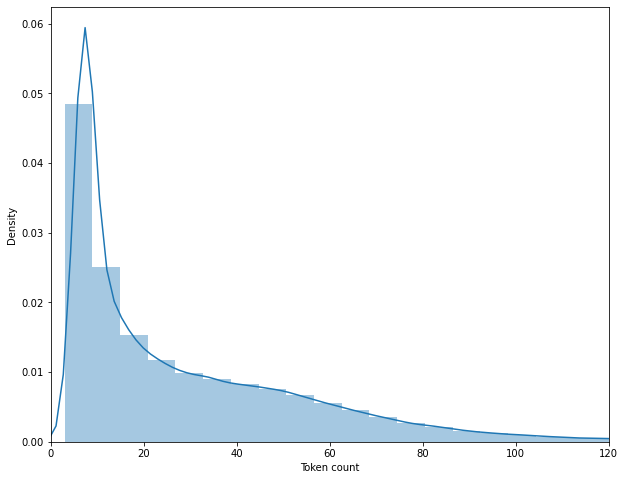

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(texts_len)
plt.xlim([0, 120])
plt.xlabel('Token count')

# DENSENET

In [46]:
size = 121
features_dim = 2048
out_size = 14

model = densenet_model(size, features_dim, out_size, pretrained=True).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()
#model = model.cuda()

In [47]:
ls

Performance_Check.ipynb  m-epoch_FL2.pth.tar         m-epoch_FL_ResNet3.pth.tar
__pycache__/             m-epoch_FL3.pth.tar         model_saved/
base3.py                 m-epoch_FL_ResNet1.pth.tar  train_mod.csv
m-epoch_FL1.pth.tar      m-epoch_FL_ResNet2.pth.tar  valid_mod.csv


In [48]:
def load_model(load_path, model):
    load_path = load_path
    checkpoint = torch.load(load_path)
    state_dict = {k.replace("img_backbone.", "module."): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict, strict=False)

## Original

In [49]:
load_path = "model_saved/m-epoch_FL_densenet1.pth.tar"
load_model(load_path, model)

In [50]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8228874986115555
No Finding   0.9071241258741258
Enlarged Cardiomediastinum   0.5201767304860089
Cardiomegaly   0.8358957219251337
Lung Opacity   0.9156359979889391
Lung Lesion   0.34328358208955223
Edema   0.9342261904761905
Consolidation   0.8536764705882354
Pneumonia   0.8395618556701031
Atelectasis   0.8192125984251969
Pneumothorax   0.9472527472527472
Pleural Effusion   0.9311594202898551
Pleural Other   0.9104477611940298
Fracture   0.9398842796901049


In [51]:
load_path = "model_saved/m-epoch_FL_densenet2.pth.tar"
load_model(load_path, model)

In [52]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7934229595768966
No Finding   0.9112762237762237
Enlarged Cardiomediastinum   0.4650957290132548
Cardiomegaly   0.7631461675579323
Lung Opacity   0.9166415284062344
Lung Lesion   0.29850746268656714
Edema   0.9525297619047619
Consolidation   0.8284926470588235
Pneumonia   0.714561855670103
Atelectasis   0.8035695538057743
Pneumothorax   0.9164835164835164
Pleural Effusion   0.9421422101449275
Pleural Other   0.8606965174129353
Fracture   0.9413553005786015


In [53]:
load_path = "model_saved/m-epoch_FL_densenet3.pth.tar"
load_model(load_path, model)

In [54]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8654556482082858
No Finding   0.895104895104895
Enlarged Cardiomediastinum   0.6635247913598429
Cardiomegaly   0.827874331550802
Lung Opacity   0.902262443438914
Lung Lesion   0.7960199004975125
Edema   0.9450892857142857
Consolidation   0.8650735294117646
Pneumonia   0.7693298969072164
Atelectasis   0.8415748031496063
Pneumothorax   0.9106227106227107
Pleural Effusion   0.9279891304347826
Pleural Other   0.9601990049751243
Fracture   0.946258703540257


## CLIP

In [111]:
load_path = "model_saved/m-epoch_FL_densenet_clip1.pth.tar"
load_model(load_path, model)

In [112]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7389302173835564
No Finding   0.8990384615384615
Enlarged Cardiomediastinum   0.3363770250368189
Cardiomegaly   0.7999108734402852
Lung Opacity   0.8751131221719457
Lung Lesion   0.07960199004975121
Edema   0.9239583333333333
Consolidation   0.8292279411764705
Pneumonia   0.7667525773195876
Atelectasis   0.7780577427821522
Pneumothorax   0.736996336996337
Pleural Effusion   0.8945878623188406
Pleural Other   0.8159203980099503
Fracture   0.8705501618122977


In [113]:
load_path = "model_saved/m-epoch_FL_densenet_clip2.pth.tar"
load_model(load_path, model)

In [114]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7908817588008369
No Finding   0.9049388111888111
Enlarged Cardiomediastinum   0.6050073637702504
Cardiomegaly   0.8073752228163992
Lung Opacity   0.8957264957264958
Lung Lesion   0.1691542288557214
Edema   0.9233630952380952
Consolidation   0.8487132352941176
Pneumonia   0.7989690721649485
Atelectasis   0.7980052493438321
Pneumothorax   0.7736263736263735
Pleural Effusion   0.9209692028985507
Pleural Other   0.9303482587064676
Fracture   0.9052662547808179


In [115]:
load_path = "model_saved/m-epoch_FL_densenet_clip3.pth.tar"
load_model(load_path, model)

In [116]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8056834784890387
No Finding   0.913243006993007
Enlarged Cardiomediastinum   0.5740795287187039
Cardiomegaly   0.8265374331550801
Lung Opacity   0.9117144293614882
Lung Lesion   0.07462686567164178
Edema   0.9313988095238095
Consolidation   0.8821691176470587
Pneumonia   0.8859536082474228
Atelectasis   0.8358005249343833
Pneumothorax   0.852014652014652
Pleural Effusion   0.9144021739130435
Pleural Other   0.9402985074626866
Fracture   0.931646562714524


## VICREG

In [135]:
load_path = "model_saved/m-epoch_FL_densenet_vicreg1.pth.tar"
load_model(load_path, model)

In [136]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7523419123478561
No Finding   0.9066870629370629
Enlarged Cardiomediastinum   0.40314187530682377
Cardiomegaly   0.8590686274509804
Lung Opacity   0.8968325791855204
Lung Lesion   0.1990049751243781
Edema   0.9375
Consolidation   0.8147058823529412
Pneumonia   0.6623711340206185
Atelectasis   0.7829921259842519
Pneumothorax   0.7772893772893773
Pleural Effusion   0.9215353260869565
Pleural Other   0.7562189054726368
Fracture   0.8630969893105817


In [137]:
load_path = "model_saved/m-epoch_FL_densenet_vicreg2.pth.tar"
load_model(load_path, model)

In [138]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8482944260468278
No Finding   0.8981643356643356
Enlarged Cardiomediastinum   0.6233676975945017
Cardiomegaly   0.8331105169340464
Lung Opacity   0.9084967320261438
Lung Lesion   0.7860696517412935
Edema   0.9370535714285713
Consolidation   0.8545955882352942
Pneumonia   0.7403350515463918
Atelectasis   0.7951706036745407
Pneumothorax   0.8241758241758241
Pleural Effusion   0.928328804347826
Pleural Other   0.9502487562189055
Fracture   0.9487104050210846


In [139]:
load_path = "model_saved/m-epoch_FL_densenet_vicreg3.pth.tar"
load_model(load_path, model)

In [140]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8253546756484231
No Finding   0.8830856643356644
Enlarged Cardiomediastinum   0.6073637702503683
Cardiomegaly   0.8594028520499108
Lung Opacity   0.9040723981900453
Lung Lesion   0.4776119402985075
Edema   0.9208333333333333
Consolidation   0.8555147058823529
Pneumonia   0.8099226804123711
Atelectasis   0.7982152230971129
Pneumothorax   0.8227106227106227
Pleural Effusion   0.9150815217391304
Pleural Other   0.9353233830845771
Fracture   0.9404726880455035


## SIMCLR

In [129]:
load_path = "model_saved/m-epoch_FL_densenet_simclr1.pth.tar"
load_model(load_path, model)

In [130]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7729825985668243
No Finding   0.9007867132867133
Enlarged Cardiomediastinum   0.4418262150220913
Cardiomegaly   0.8294340463458111
Lung Opacity   0.9097033685268979
Lung Lesion   0.30348258706467657
Edema   0.9311011904761906
Consolidation   0.8500000000000001
Pneumonia   0.6726804123711341
Atelectasis   0.7781627296587926
Pneumothorax   0.7882783882783883
Pleural Effusion   0.9213088768115942
Pleural Other   0.845771144278607
Fracture   0.876238109247818


In [131]:
load_path = "model_saved/m-epoch_FL_densenet_simclr2.pth.tar"
load_model(load_path, model)

In [132]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8318510128055566
No Finding   0.8968531468531469
Enlarged Cardiomediastinum   0.636033382425135
Cardiomegaly   0.8177361853832442
Lung Opacity   0.8997486173956762
Lung Lesion   0.6766169154228856
Edema   0.9264880952380952
Consolidation   0.8255514705882352
Pneumonia   0.7119845360824741
Atelectasis   0.7483464566929133
Pneumothorax   0.841025641025641
Pleural Effusion   0.9239130434782609
Pleural Other   0.9651741293532339
Fracture   0.9445915465332941


In [133]:
load_path = "model_saved/m-epoch_FL_densenet_simclr3.pth.tar"
load_model(load_path, model)

In [134]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8431031390187983
No Finding   0.8881118881118881
Enlarged Cardiomediastinum   0.620225822287678
Cardiomegaly   0.8270944741532977
Lung Opacity   0.9134238310708899
Lung Lesion   0.5124378109452736
Edema   0.9436011904761904
Consolidation   0.8624999999999999
Pneumonia   0.8099226804123711
Atelectasis   0.8183727034120736
Pneumothorax   0.9362637362637363
Pleural Effusion   0.9176856884057971
Pleural Other   0.9552238805970149
Fracture   0.9554771011081691


## SLIP VICREG

In [123]:
load_path = "model_saved/m-epoch_FL_densenet_slip_vicreg1.pth.tar"
load_model(load_path, model)

In [124]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7941205250103034
No Finding   0.9073426573426573
Enlarged Cardiomediastinum   0.4893470790378007
Cardiomegaly   0.8384581105169341
Lung Opacity   0.8921065862242333
Lung Lesion   0.3681592039800995
Edema   0.9282738095238096
Consolidation   0.8446691176470589
Pneumonia   0.652061855670103
Atelectasis   0.793490813648294
Pneumothorax   0.873992673992674
Pleural Effusion   0.9277626811594202
Pleural Other   0.8855721393034826
Fracture   0.9223300970873786


In [125]:
load_path = "model_saved/m-epoch_FL_densenet_slip_vicreg2.pth.tar"
load_model(load_path, model)

In [126]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8360058545984561
No Finding   0.9060314685314685
Enlarged Cardiomediastinum   0.538831615120275
Cardiomegaly   0.8316622103386809
Lung Opacity   0.9004524886877828
Lung Lesion   0.7761194029850746
Edema   0.934970238095238
Consolidation   0.8369485294117647
Pneumonia   0.7164948453608248
Atelectasis   0.7535958005249344
Pneumothorax   0.8637362637362638
Pleural Effusion   0.9302536231884058
Pleural Other   0.945273631840796
Fracture   0.9337059919584192


In [127]:
load_path = "model_saved/m-epoch_FL_densenet_slip_vicreg3.pth.tar"
load_model(load_path, model)

In [128]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8472015685713887
No Finding   0.896416083916084
Enlarged Cardiomediastinum   0.5873343151693667
Cardiomegaly   0.8413547237076648
Lung Opacity   0.9151332327802916
Lung Lesion   0.572139303482587
Edema   0.9459821428571429
Consolidation   0.8691176470588236
Pneumonia   0.8208762886597939
Atelectasis   0.7984251968503937
Pneumothorax   0.9274725274725275
Pleural Effusion   0.9215353260869565
Pleural Other   0.9601990049751243
Fracture   0.9576345984112974


## SLIP SIMCLR

In [147]:
load_path = "model_saved/m-epoch_FL_densenet_slip_simclr1.pth.tar"
load_model(load_path, model)

In [148]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7643685908865462
No Finding   0.9206730769230769
Enlarged Cardiomediastinum   0.42052037309769275
Cardiomegaly   0.8547237076648841
Lung Opacity   0.8949220713926596
Lung Lesion   0.24378109452736318
Edema   0.9200892857142856
Consolidation   0.8494485294117647
Pneumonia   0.5663659793814433
Atelectasis   0.7596850393700788
Pneumothorax   0.8336996336996336
Pleural Effusion   0.9227807971014493
Pleural Other   0.8557213930348259
Fracture   0.894380700205943


In [149]:
load_path = "model_saved/m-epoch_FL_densenet_slip_simclr2.pth.tar"
load_model(load_path, model)

In [150]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8209386452597754
No Finding   0.89881993006993
Enlarged Cardiomediastinum   0.5673048600883652
Cardiomegaly   0.8194073083778967
Lung Opacity   0.9011563599798894
Lung Lesion   0.46766169154228854
Edema   0.9369047619047619
Consolidation   0.8279411764705882
Pneumonia   0.7899484536082475
Atelectasis   0.7819422572178477
Pneumothorax   0.8498168498168499
Pleural Effusion   0.9239130434782609
Pleural Other   0.9701492537313433
Fracture   0.9372364420908109


In [151]:
load_path = "model_saved/m-epoch_FL_densenet_slip_simclr3.pth.tar"
load_model(load_path, model)

In [152]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.8527790331692864
No Finding   0.8883304195804196
Enlarged Cardiomediastinum   0.6106038291605301
Cardiomegaly   0.8094919786096257
Lung Opacity   0.8976370035193565
Lung Lesion   0.7412935323383085
Edema   0.9447916666666667
Consolidation   0.8503676470588235
Pneumonia   0.8131443298969072
Atelectasis   0.8002099737532808
Pneumothorax   0.9157509157509157
Pleural Effusion   0.9115715579710145
Pleural Other   0.9402985074626866
Fracture   0.9626360694321859


# Linear Probing

## Original

In [12]:
path = "model_saved/m-epoch_FL_resnet_lp1.pth.tar"
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.6419114160440883
No Finding   0.8540209790209791
Enlarged Cardiomediastinum   0.4559646539027983
Cardiomegaly   0.6678921568627452
Lung Opacity   0.808044243338361
Lung Lesion   0.04477611940298509
Edema   0.7950892857142857
Consolidation   0.7922794117647058
Pneumonia   0.6623711340206185
Atelectasis   0.7633595800524935
Pneumothorax   0.7494505494505495
Pleural Effusion   0.7778532608695653
Pleural Other   0.25373134328358204
Fracture   0.7200156908894774


In [13]:
path1 = 'model_saved/m-epoch_FL_resnet_lp2.pth.tar'
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path1, class_names)

AUROC mean  0.6551112739068264
No Finding   0.8690996503496503
Enlarged Cardiomediastinum   0.4251350024545901
Cardiomegaly   0.6705659536541889
Lung Opacity   0.804927099044746
Lung Lesion   0.02487562189054726
Edema   0.8133928571428571
Consolidation   0.7860294117647059
Pneumonia   0.7203608247422681
Atelectasis   0.7596850393700787
Pneumothorax   0.747985347985348
Pleural Effusion   0.7793251811594203
Pleural Other   0.3830845771144279
Fracture   0.7319799941159163


In [14]:
path3 = 'model_saved/m-epoch_FL_resnet_lp3.pth.tar'
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path3, class_names)

AUROC mean  0.6628867769265889
No Finding   0.8721590909090909
Enlarged Cardiomediastinum   0.4705940108001964
Cardiomegaly   0.6727941176470589
Lung Opacity   0.8143790849673203
Lung Lesion   0.02487562189054726
Edema   0.8165178571428572
Consolidation   0.8001838235294118
Pneumonia   0.731958762886598
Atelectasis   0.7649343832020997
Pneumothorax   0.7289377289377289
Pleural Effusion   0.7924592391304348
Pleural Other   0.3980099502487562
Fracture   0.7297244287535549


## CLIP

In [15]:
load_path = "model_saved/m-epoch_FL_resnet_clip_lp1.pth.tar"
load_model(load_path, model)

In [16]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.5740112820066824
No Finding   0.5563811188811189
Enlarged Cardiomediastinum   0.3696612665684831
Cardiomegaly   0.5424465240641712
Lung Opacity   0.6083459024635495
Lung Lesion   0.900497512437811
Edema   0.5626488095238096
Consolidation   0.7503676470588235
Pneumonia   0.7016752577319587
Atelectasis   0.5956955380577429
Pneumothorax   0.5655677655677656
Pleural Effusion   0.6913496376811595
Pleural Other   0.13432835820895528
Fracture   0.483181327841522


In [17]:
load_path = "model_saved/m-epoch_FL_resnet_clip_lp2.pth.tar"
load_model(load_path, model)

In [18]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.5800559281393045
No Finding   0.5749562937062936
Enlarged Cardiomediastinum   0.3858615611192931
Cardiomegaly   0.5482397504456328
Lung Opacity   0.6190045248868778
Lung Lesion   0.8855721393034826
Edema   0.5686011904761904
Consolidation   0.7255514705882353
Pneumonia   0.6804123711340206
Atelectasis   0.6121784776902885
Pneumothorax   0.5377289377289377
Pleural Effusion   0.7093523550724639
Pleural Other   0.1990049751243781
Fracture   0.4942630185348632


In [20]:
load_path = "model_saved/m-epoch_FL_resnet_clip_lp3.pth.tar"
load_model(load_path, model)

In [21]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.5760752692652003
No Finding   0.5751748251748252
Enlarged Cardiomediastinum   0.3806578301423662
Cardiomegaly   0.5007798573975044
Lung Opacity   0.6239316239316239
Lung Lesion   0.8407960199004976
Edema   0.5770833333333333
Consolidation   0.7235294117647059
Pneumonia   0.6514175257731959
Atelectasis   0.6299212598425197
Pneumothorax   0.5487179487179488
Pleural Effusion   0.6493432971014492
Pleural Other   0.2885572139303483
Fracture   0.4990683534372855


## VICREG

In [22]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_lp1.pth.tar"
load_model(load_path, model)

In [23]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7204818627489432
No Finding   0.8953234265734266
Enlarged Cardiomediastinum   0.593127147766323
Cardiomegaly   0.686608734402852
Lung Opacity   0.8393162393162393
Lung Lesion   0.05970149253731338
Edema   0.8998511904761903
Consolidation   0.8380514705882353
Pneumonia   0.7261597938144331
Atelectasis   0.7783727034120735
Pneumothorax   0.8388278388278388
Pleural Effusion   0.8125000000000001
Pleural Other   0.6716417910447761
Fracture   0.7267823869765617


In [24]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_lp2.pth.tar"
load_model(load_path, model)

In [25]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7203766446149019
No Finding   0.9034090909090909
Enlarged Cardiomediastinum   0.5671084928816887
Cardiomegaly   0.6910650623885918
Lung Opacity   0.8396178984414279
Lung Lesion   0.03482587064676612
Edema   0.9019345238095238
Consolidation   0.8352941176470587
Pneumonia   0.7564432989690721
Atelectasis   0.7722834645669292
Pneumothorax   0.8285714285714285
Pleural Effusion   0.8114809782608695
Pleural Other   0.6865671641791045
Fracture   0.7362949887221732


In [26]:
load_path = "model_saved/m-epoch_FL_resnet_vicreg_lp3.pth.tar"
load_model(load_path, model)

In [27]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7344333555610798
No Finding   0.9060314685314685
Enlarged Cardiomediastinum   0.6237604320078547
Cardiomegaly   0.7027629233511586
Lung Opacity   0.844746103569633
Lung Lesion   0.03482587064676612
Edema   0.9026785714285714
Consolidation   0.8389705882352941
Pneumonia   0.7693298969072164
Atelectasis   0.7785826771653543
Pneumothorax   0.8043956043956043
Pleural Effusion   0.8268795289855073
Pleural Other   0.7761194029850746
Fracture   0.7385505540845347


## SIMCLR

In [28]:
load_path = "model_saved/m-epoch_FL_resnet_simclr_lp1.pth.tar"
load_model(load_path, model)

In [29]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7250383930746747
No Finding   0.8988199300699301
Enlarged Cardiomediastinum   0.6108001963672066
Cardiomegaly   0.7182486631016043
Lung Opacity   0.8560080442433383
Lung Lesion   0.04477611940298509
Edema   0.9052083333333334
Consolidation   0.8628676470588235
Pneumonia   0.6920103092783505
Atelectasis   0.7733333333333333
Pneumothorax   0.8183150183150183
Pleural Effusion   0.8548460144927537
Pleural Other   0.6567164179104478
Fracture   0.7335490830636461


In [30]:
load_path = "model_saved/m-epoch_FL_resnet_simclr_lp2.pth.tar"
load_model(load_path, model)

In [31]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7257449372900044
No Finding   0.8975087412587412
Enlarged Cardiomediastinum   0.5447226313205694
Cardiomegaly   0.713903743315508
Lung Opacity   0.8543991955756661
Lung Lesion   0.03482587064676612
Edema   0.9110119047619047
Consolidation   0.8715073529411765
Pneumonia   0.7429123711340206
Atelectasis   0.7723884514435696
Pneumothorax   0.7978021978021979
Pleural Effusion   0.8624320652173912
Pleural Other   0.691542288557214
Fracture   0.7397273707953319


In [32]:
load_path = "model_saved/m-epoch_FL_resnet_simclr_lp3.pth.tar"
load_model(load_path, model)

In [33]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7350559938392067
No Finding   0.906687062937063
Enlarged Cardiomediastinum   0.6691212567501228
Cardiomegaly   0.7151292335115864
Lung Opacity   0.8518853695324284
Lung Lesion   0.04975124378109452
Edema   0.9141369047619047
Consolidation   0.8683823529411765
Pneumonia   0.7673969072164949
Atelectasis   0.7792125984251969
Pneumothorax   0.780952380952381
Pleural Effusion   0.8653759057971014
Pleural Other   0.6417910447761195
Fracture   0.7459056585270177


## SLIP VICREG

In [34]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp1.pth.tar"
load_model(load_path, model)

In [35]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7293614136277273
No Finding   0.888986013986014
Enlarged Cardiomediastinum   0.5621993127147766
Cardiomegaly   0.749108734402852
Lung Opacity   0.8316742081447964
Lung Lesion   0.14925373134328357
Edema   0.8761904761904762
Consolidation   0.8534926470588236
Pneumonia   0.7880154639175259
Atelectasis   0.779002624671916
Pneumothorax   0.8036630036630037
Pleural Effusion   0.7963088768115942
Pleural Other   0.7114427860696517
Fracture   0.692360498185741


In [36]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp2.pth.tar"
load_model(load_path, model)

In [37]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7320789913239374
No Finding   0.8913898601398602
Enlarged Cardiomediastinum   0.5668139420716741
Cardiomegaly   0.7391934046345812
Lung Opacity   0.8381096028154852
Lung Lesion   0.10447761194029848
Edema   0.8831845238095238
Consolidation   0.8558823529411765
Pneumonia   0.7963917525773196
Atelectasis   0.7760629921259843
Pneumothorax   0.8329670329670329
Pleural Effusion   0.8020833333333334
Pleural Other   0.7313432835820896
Fracture   0.6991271942728253


In [38]:
load_path = "model_saved/m-epoch_FL_resnet_slip_vicreg_lp3.pth.tar"
load_model(load_path, model)

In [39]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7310885846417412
No Finding   0.8933566433566433
Enlarged Cardiomediastinum   0.587039764359352
Cardiomegaly   0.7416443850267379
Lung Opacity   0.8430367018602313
Lung Lesion   0.02985074626865669
Edema   0.890327380952381
Consolidation   0.8599264705882352
Pneumonia   0.8041237113402062
Atelectasis   0.7801574803149607
Pneumothorax   0.8263736263736263
Pleural Effusion   0.8115942028985507
Pleural Other   0.736318407960199
Fracture   0.7004020790428558


## SLIP SIMCLR

In [40]:
load_path = "model_saved/m-epoch_FL_resnet_slip_simclr_lp1.pth.tar"
load_model(load_path, model)

In [41]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7158631496456963
No Finding   0.892263986013986
Enlarged Cardiomediastinum   0.5434462444771724
Cardiomegaly   0.7174688057040999
Lung Opacity   0.8522875816993464
Lung Lesion   0.01990049751243783
Edema   0.8708333333333333
Consolidation   0.8713235294117647
Pneumonia   0.8189432989690721
Atelectasis   0.7864566929133858
Pneumothorax   0.6871794871794872
Pleural Effusion   0.8144248188405797
Pleural Other   0.7412935323383085
Fracture   0.6903991370010787


In [42]:
load_path = "model_saved/m-epoch_FL_resnet_slip_simclr_lp2.pth.tar"
load_model(load_path, model)

In [43]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7197351246800687
No Finding   0.8975087412587414
Enlarged Cardiomediastinum   0.507707412862052
Cardiomegaly   0.723150623885918
Lung Opacity   0.8514831573655104
Lung Lesion   0.02487562189054726
Edema   0.8863095238095238
Consolidation   0.8737132352941177
Pneumonia   0.8060567010309279
Atelectasis   0.7828871391076115
Pneumothorax   0.7135531135531135
Pleural Effusion   0.8179347826086957
Pleural Other   0.7661691542288558
Fracture   0.705207413945278


In [44]:
load_path = "model_saved/m-epoch_FL_resnet_slip_simclr_lp3.pth.tar"
load_model(load_path, model)

In [45]:
path = None
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderVal, nnClassCount, path, class_names)

AUROC mean  0.7306897074943385
No Finding   0.8964160839160839
Enlarged Cardiomediastinum   0.5680903289150712
Cardiomegaly   0.7249331550802139
Lung Opacity   0.8507792860734037
Lung Lesion   0.04477611940298509
Edema   0.8956845238095238
Consolidation   0.8783088235294119
Pneumonia   0.7880154639175259
Atelectasis   0.7783727034120735
Pneumothorax   0.7406593406593407
Pleural Effusion   0.8195199275362319
Pleural Other   0.8009950248756219
Fracture   0.7124154162989114


             Atelectasis       Cardiomegaly       Consolidation       Edema Pleural      Effusion
PAPER:  0.858(0.806,0.910)  0.832(0.773,0.890)  0.899(0.854,0.944)  0.941(0.903,0.980)  0.934(0.901,0.967)
Result:    0.85070              0.84569               0.88235              0.90595          0.92142
